In [1]:
import sys, os
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import numpy.matlib
import weatherbench2 as wb
#import metpy
import copy
import wrf
import time
#from metpy.units import units
import cartopy.crs as ccrs
print('modules loaded')
import datetime

modules loaded


In [5]:
print(days)

[22 21 20 19 18 17 16 15 14]


In [4]:
year=2020; month=4; day=np.arange(12,14,1); days=day[0]-np.arange(1,10)
year=2020; month=5; day=23; days=day-np.arange(1,10)
figpath='/users/mfeldman/figs/'
#EVENT SELECTION ERA5
era5='gs://weatherbench2/datasets/era5/1959-2022-6h-1440x721.zarr'
xr_era5=xr.open_zarr(era5)
xr_era5=xr_era5.sel(time=xr_era5.time.dt.year.isin([year]))
xr_era5=xr_era5.sel(time=xr_era5.time.dt.month.isin([month]))#np.arange(3,10)))
xr_era5=xr_era5.sel(time=xr_era5.time.dt.day.isin([day]))
zsurf_c=xr_era5['geopotential_at_surface']
init=xr_era5.time[0].dt.strftime('%Y%m%d%H').values; print(init)
plevel=copy.deepcopy(xr_era5.level.values)
        
xr_era5['pressure'] = (('level'), plevel)
plevel=xr_era5.pressure
xr_dataset = xr_era5.assign_coords(level=np.arange(len(plevel)))
tlevel=xr_era5.temperature
qlevel=xr_era5.specific_humidity
plevel_dim=np.ones([1,len(plevel),1,1])
zlevel=xr_era5.geopotential
ulevel=xr_era5.u_component_of_wind
vlevel=xr_era5.v_component_of_wind
for n1 in range(len(plevel.data)):
    plevel_dim[0,n1,0,0]=plevel[n1]
plevel_exp=(tlevel/tlevel)*plevel_dim
psurf=xr_era5.mean_sea_level_pressure
tsurf=xr_era5['2m_temperature']
zsurf = zsurf_c.expand_dims(dim={"time": psurf.time}, axis=0)

ps_era=psurf/100
zs=zsurf/9.81
zl=zlevel/9.81

2020052300


In [ ]:
era_cape=wrf.cape_2d(pres_hpa=plevel_exp, tkel=tlevel, qv=qlevel, height=zl, terrain=zs, psfc_hpa=ps_era, ter_follow=False)
era_srh=wrf.srhel(u=ulevel, v=vlevel, height=zl, terrain=zs, top=3000.0)

In [9]:
era_cape=era_cape.assign_coords(longitude=psurf.longitude.values);
era_cape=era_cape.assign_coords(latitude=psurf.latitude.values);
era_cape=era_cape.assign_coords(time=psurf.time.values)
cm=plt.cm.Reds
cm.set_bad(color="grey")
cm.set_under(color="grey")
p = era_cape.sel(mcape_mcin_lcl_lfc='mcape',latitude=slice(50,20),longitude=slice(250,300)).plot(x="longitude", y="latitude", col="time", col_wrap=4,transform=ccrs.PlateCarree(), subplot_kws={'projection':ccrs.PlateCarree()}\
                ,cmap=cm,vmin=200,vmax=3000,levels=np.arange(200,3000,100),extend='both')# col_wrap=4)
for ax in p.axs.flat:
                ax.coastlines()
f=p.fig
f.savefig(figpath+init+'_era5_cape.png',  dpi=300, bbox_inches='tight')
plt.close()

era_srh=era_srh.assign_coords(longitude=psurf.longitude.values);
era_srh=era_srh.assign_coords(latitude=psurf.latitude.values);
era_srh=era_srh.assign_coords(time=psurf.time.values)

cm=plt.cm.Reds
cm.set_under(color="grey")
p = era_srh.sel(latitude=slice(50,20),longitude=slice(250,300)).plot(x="longitude", y="latitude", col="time", col_wrap=4,transform=ccrs.PlateCarree(), subplot_kws={'projection':ccrs.PlateCarree()}\
                ,cmap=cm,vmin=0,vmax=1000,levels=np.arange(0,1000,50),extend='both')# col_wrap=4)
for ax in p.axs.flat:
                ax.coastlines()
f=p.fig
f.savefig(figpath+init+'_era5_srh.png',  dpi=300, bbox_inches='tight')
plt.close()

In [4]:
era_cape=era_cape.assign_coords(longitude=psurf.longitude.values);
era_cape=era_cape.assign_coords(latitude=psurf.latitude.values); era_cape=era_cape.assign_coords(time=psurf.time.values)
era_srh=era_srh.assign_coords(longitude=psurf.longitude.values);
era_srh=era_srh.assign_coords(latitude=psurf.latitude.values); era_srh=era_srh.assign_coords(time=psurf.time.values)

In [10]:
ifs_init='gs://weatherbench2/datasets/hres_t0/2016-2022-6h-1440x721.zarr'
xr_model=xr.open_zarr(ifs_init)
xr_init=xr_model.sel(time=xr_model.time.dt.year.isin([year]))
xr_init=xr_init.sel(time=xr_init.time.dt.month.isin([month]))#np.arange(3,10)))
xr_init=xr_init.sel(time=xr_init.time.dt.day.isin([day]))
init=xr_init.time[0].dt.strftime('%Y%m%d%H').values; print(init)
#xr_init=xr_init.sel(prediction_timedelta=xr_init.prediction_timedelta[0])
print(xr_init.dims)
#xr_init=xr_init.squeeze(dim='prediction_timedelta')

xr_init = xr_init.sortby('level', ascending=False)
plevel=copy.deepcopy(xr_init.level.values)
xr_init['pressure'] = (('level'), plevel)
plevel=xr_init.pressure
xr_init = xr_init.assign_coords(level=np.arange(len(plevel)))

tlevel=xr_init.temperature
qlevel=xr_init.specific_humidity
plevel_dim=np.ones([1,len(plevel),1,1])
zlevel=xr_init.geopotential
ulevel=xr_init.u_component_of_wind
vlevel=xr_init.v_component_of_wind
for n1 in range(len(plevel.data)):
    plevel_dim[0,n1,0,0]=plevel[n1]
plevel_exp=(tlevel/tlevel)*plevel_dim

psurf=xr_init.mean_sea_level_pressure
tsurf=xr_init['2m_temperature']
zsurf = zsurf_c.expand_dims(dim={"time": psurf.time}, axis=0)

ps=psurf/100
zs=zsurf/9.81
zl=zlevel/9.81

init_cape=wrf.cape_2d(pres_hpa=plevel_exp, tkel=tlevel, qv=qlevel, height=zl, terrain=zs, psfc_hpa=ps, ter_follow=False)
init_srh=wrf.srhel(u=ulevel, v=vlevel, height=zl, terrain=zs, top=3000.0)

init_cape=init_cape.assign_coords(longitude=psurf.longitude.values);
init_cape=init_cape.assign_coords(latitude=psurf.latitude.values);
init_cape=init_cape.assign_coords(time=psurf.time.values)
init_srh=init_srh.assign_coords(longitude=psurf.longitude.values);
init_srh=init_srh.assign_coords(latitude=psurf.latitude.values);
init_srh=init_srh.assign_coords(time=psurf.time.values)

2020052300
Frozen({'time': 4, 'latitude': 721, 'longitude': 1440, 'level': 13})


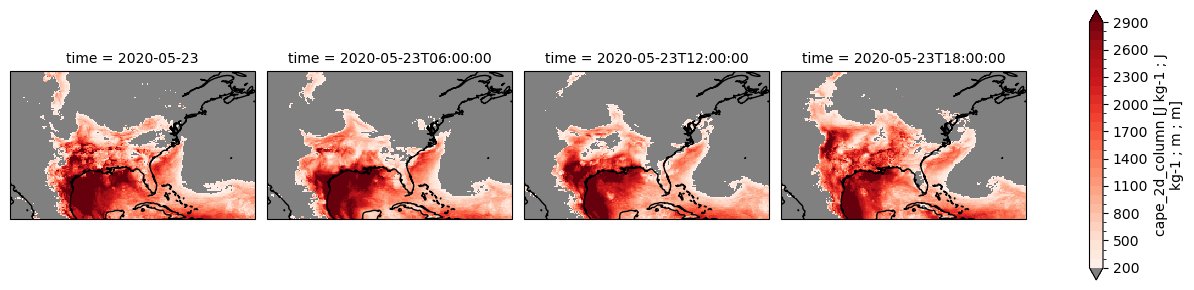

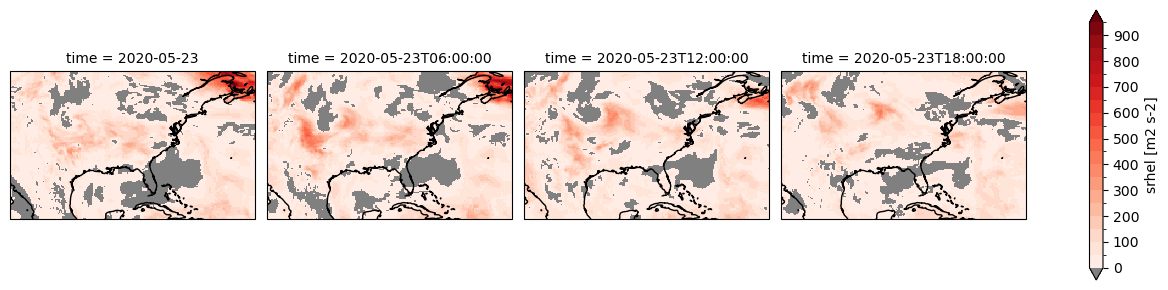

In [11]:
cm=plt.cm.Reds
cm.set_bad(color="grey")
cm.set_under(color="grey")
p = init_cape.sel(mcape_mcin_lcl_lfc='mcape',latitude=slice(20,50),longitude=slice(250,300)).plot(x="longitude", y="latitude", col="time", col_wrap=4,transform=ccrs.PlateCarree(), subplot_kws={'projection':ccrs.PlateCarree()}\
                ,cmap=cm,vmin=200,vmax=3000,levels=np.arange(200,3000,100),extend='both')# col_wrap=4)
for ax in p.axs.flat:
                ax.coastlines()
f=p.fig
f.savefig(figpath+init+'_ifsinit_cape.png',  dpi=300, bbox_inches='tight')
#plt.close()

cm=plt.cm.Reds
cm.set_under(color="grey")
p = init_srh.sel(latitude=slice(20,50),longitude=slice(250,300)).plot(x="longitude", y="latitude", col="time", col_wrap=4,transform=ccrs.PlateCarree(), subplot_kws={'projection':ccrs.PlateCarree()}\
                ,cmap=cm,vmin=0,vmax=1000,levels=np.arange(0,1000,50),extend='both')# col_wrap=4)
for ax in p.axs.flat:
                ax.coastlines()
f=p.fig
f.savefig(figpath+init+'_ifsinit_srh.png',  dpi=300, bbox_inches='tight')
#plt.close()

In [16]:
print(init_cape.shape,init_cape.dims)
print(init_cape.time)

(4, 4, 721, 1440) ('mcape_mcin_lcl_lfc', 'time', 'latitude', 'longitude')
<xarray.DataArray 'time' (time: 4)>
array(['2020-04-12T00:00:00.000000000', '2020-04-12T12:00:00.000000000',
       '2020-04-13T00:00:00.000000000', '2020-04-13T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2020-04-12 ... 2020-04-13T12:00:00


In [21]:
start=xr_era5.time[0]
end=xr_era5.time[-1]

ref_cape=init_cape; ref_srh=init_srh
ref_cape=era_cape; ref_srh=era_srh
#LOADING FORECAST DATASET
model='pangu'
#model='ifs'
# model='fuxi'
# model='keisler'
# model='spherical'
latslice=slice(50,20)
#latslice=slice(20,50)
dataset='gs://weatherbench2/datasets/pangu/2018-2022_0012_0p25.zarr'
#dataset='gs://weatherbench2/datasets/hres/2016-2022-0012-1440x721.zarr'
# dataset='gs://weatherbench2/datasets/fuxi/2020-1440x721.zarr'
# dataset='gs://weatherbench2/datasets/keisler/2020-360x181.zarr'
# dataset='gs://weatherbench2/datasets/sphericalcnn/2020-240x121_equiangular_with_poles.zarr'
# days=[6,7,8,9,10,11,12]
hours=[0,12]
for d in days[:]:
    for hour in hours[:]:
        xr_model=xr.open_zarr(dataset)
        xr_dataset=xr_model.sel(time=xr_model.time.dt.year.isin([year]))
        xr_dataset=xr_dataset.sel(time=xr_dataset.time.dt.month.isin([month]))
        xr_dataset=xr_dataset.sel(time=xr_dataset.time.dt.day.isin([d]))
        xr_dataset=xr_dataset.sel(time=xr_dataset.time.dt.hour.isin([hour]))
        fcst_init=xr_dataset.time[0]
        init=fcst_init.dt.strftime('%Y%m%d%H').values; print(init)
        xr_dataset=xr_dataset.sel(prediction_timedelta=slice(start-fcst_init,end-fcst_init))
        xr_dataset = xr_dataset.sortby('level', ascending=False)
        
        plevel=copy.deepcopy(xr_dataset.level.values)
        
        xr_dataset['pressure'] = (('level'), plevel)
        plevel=xr_dataset.pressure
        xr_dataset = xr_dataset.assign_coords(level=np.arange(len(plevel)))
        
        tlevel=xr_dataset.temperature
        qlevel=xr_dataset.specific_humidity
        plevel_dim=np.ones([1,len(plevel),1,1])
        zlevel=xr_dataset.geopotential
        ulevel=xr_dataset.u_component_of_wind
        vlevel=xr_dataset.v_component_of_wind
        for n1 in range(len(plevel.data)):
            plevel_dim[0,n1,0,0]=plevel[n1]
        plevel_exp=(tlevel/tlevel)*plevel_dim
        
        psurf=xr_dataset.mean_sea_level_pressure
        tsurf=xr_dataset['2m_temperature']
        zsurf = zsurf_c.expand_dims(dim={"time": psurf.time}, axis=0)
        zsurf = zsurf.expand_dims(dim={"prediction_timedelta": psurf.prediction_timedelta}, axis=1)
        
        ps=psurf/100
        zs=zsurf/9.81
        zl=zlevel/9.81

        cape=wrf.cape_2d(pres_hpa=plevel_exp, tkel=tlevel, qv=qlevel, height=zl, terrain=zs, psfc_hpa=ps, ter_follow=False)
        srh=wrf.srhel(u=ulevel, v=vlevel, height=zl, terrain=zs, top=3000.0)

        cape=cape.assign_coords(longitude=psurf.longitude.values);
        cape=cape.assign_coords(latitude=psurf.latitude.values);
        cape=cape.assign_coords(prediction_timedelta=ps_era.time.values)

        srh=srh.assign_coords(longitude=psurf.longitude.values);
        srh=srh.assign_coords(latitude=psurf.latitude.values);
        srh=srh.assign_coords(prediction_timedelta=ps_era.time.values)

        cape=cape.squeeze(dim='time'); cape=cape.rename({'prediction_timedelta':'time'})
        srh=srh.squeeze(dim='time'); srh=srh.rename({'prediction_timedelta':'time'})
        
        cm=plt.cm.Reds
        cm.set_bad(color="grey")
        cm.set_under(color="grey")
        p = cape.sel(mcape_mcin_lcl_lfc='mcape',latitude=latslice,longitude=slice(250,300)).plot(x="longitude", y="latitude", col="time",\
                         col_wrap=4,transform=ccrs.PlateCarree(), subplot_kws={'projection':ccrs.PlateCarree()},\
                         cmap=cm,vmin=200,vmax=3000,levels=np.arange(200,3000,100),extend='both')# col_wrap=4)
        for ax in p.axs.flat:
                        ax.coastlines()
        f=p.fig
        f.savefig(figpath+model+init+'_cape.png',  dpi=300, bbox_inches='tight')
        plt.close()

        
        cm=plt.cm.Reds
        cm.set_bad(color="grey")
        cm.set_under(color="grey")
        p = srh.sel(latitude=latslice,longitude=slice(250,300)).plot(x="longitude", y="latitude", col="time",\
                         col_wrap=4,transform=ccrs.PlateCarree(), subplot_kws={'projection':ccrs.PlateCarree()},\
                         cmap=cm,vmin=0,vmax=1000,levels=np.arange(0,1000,50),extend='both')# col_wrap=4)
        for ax in p.axs.flat:
                        ax.coastlines()
        f=p.fig
        f.savefig(figpath+model+init+'_srh.png',  dpi=300, bbox_inches='tight')
        plt.close()

        #cape=cape.sel(time=cape.time.dt.hour.isin([0,12]))
        #srh=srh.sel(time=srh.time.dt.hour.isin([0,12]))
        cm=plt.cm.RdBu_r
        cm.set_bad(color="grey")
        dcape=cape.fillna(0)-ref_cape.fillna(0)
        dsrh=srh.fillna(0)-ref_srh.fillna(0)
        p = dcape.sel(mcape_mcin_lcl_lfc='mcape',latitude=latslice,longitude=slice(250,300)).plot(x="longitude", y="latitude", col="time",\
                         col_wrap=4,transform=ccrs.PlateCarree(), subplot_kws={'projection':ccrs.PlateCarree()},\
                         cmap=cm,vmin=-1000,vmax=1000,levels=np.arange(-1000,1010,100),extend='both')# col_wrap=4)
        for ax in p.axs.flat:
                        ax.coastlines()
        f=p.fig
        f.savefig(figpath+model+init+'_cape_d.png',  dpi=300, bbox_inches='tight')
        plt.close()


        cm=plt.cm.RdBu_r
        cm.set_bad(color="grey")
        p = dsrh.sel(latitude=latslice,longitude=slice(250,300)).plot(x="longitude", y="latitude", col="time",\
                         col_wrap=4,transform=ccrs.PlateCarree(), subplot_kws={'projection':ccrs.PlateCarree()},\
                         cmap=cm,vmin=-500,vmax=500,levels=np.arange(-500,505,50),extend='both')# col_wrap=4)
        for ax in p.axs.flat:
                        ax.coastlines()
        f=p.fig
        f.savefig(figpath+model+init+'_srh_d.png',  dpi=300, bbox_inches='tight')
        plt.close()

2020052200
2020052212
2020052100
2020052112
2020052000
2020052012
2020051900
2020051912
2020051800
2020051812
2020051700
2020051712


In [32]:
start=xr_era5.time[0]
end=xr_era5.time[-1]
mlpath='/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ML_PREDICT/panguweather/Data_Monika/'
import glob
#ref_cape=init_cape; ref_srh=init_srh
#LOADING FORECAST DATASET
model='pangu_dawn'
latslice=slice(50,20)
latslice=slice(20,50)
year=2020; month=4
days=[6,7,8,9,10,11,12]
hours=[0,12]
for day in days[:1]:
    for hour in hours[:1]:
        filelist=sorted(glob.glob(mlpath+'*'+str(year)+str(month).zfill(2)+str(day).zfill(2)+'_t_'+str(hour).zfill(4)+'*'))
        #print(filelist)
        st=datetime.datetime(start.dt.year.values,start.dt.month.values,start.dt.day.values,start.dt.hour.values)
        et=datetime.datetime(end.dt.year.values,end.dt.month.values,end.dt.day.values,end.dt.hour.values)
        dat=datetime.datetime(year, month, day, hour)
        lt1=int((st-dat).total_seconds() / 3600)#,tzinfo=datetime.timezone.utc)
        lt2=int((et-dat).total_seconds() / 3600)
        lt=np.arange(lt1,lt2+1,6).astype(str)
        print(lt)
        filtered_files = [file for file in filelist if any(part in file for part in lt)]
        print(filtered_files)
        xr_dataset=xr.open_mfdataset(filtered_files,concat_dim='prediction_timedelta',combine='nested',engine='cfgrib')
        xr_dataset.close()
        xr_tdata=xr.open_mfdataset(filtered_files,concat_dim='prediction_timedelta',combine='nested',engine='cfgrib', backend_kwargs={'filter_by_keys': {'shortName': 't2m'}})
        xr_tdata.close()

        #xr_model=xr.open_zarr(dataset)

['144' '150' '156' '162' '168' '174' '180' '186']
['/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ML_PREDICT/panguweather/Data_Monika/pangu_d_20200406_t_0000_144h.grib', '/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ML_PREDICT/panguweather/Data_Monika/pangu_d_20200406_t_0000_150h.grib', '/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ML_PREDICT/panguweather/Data_Monika/pangu_d_20200406_t_0000_156h.grib', '/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ML_PREDICT/panguweather/Data_Monika/pangu_d_20200406_t_0000_162h.grib', '/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ML_PREDICT/panguweather/Data_Monika/pangu_d_20200406_t_0000_168h.grib']


skipping variable: paramId==167 shortName='t2m'
Traceback (most recent call last):
  File "/users/mfeldman/.conda/envs/wb/lib/python3.10/site-packages/cfgrib/dataset.py", line 680, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/users/mfeldman/.conda/envs/wb/lib/python3.10/site-packages/cfgrib/dataset.py", line 611, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='heightAboveGround' value=Variable(dimensions=(), data=10.0) new_value=Variable(dimensions=(), data=2.0)
skipping variable: paramId==167 shortName='t2m'
Traceback (most recent call last):
  File "/users/mfeldman/.conda/envs/wb/lib/python3.10/site-packages/cfgrib/dataset.py", line 680, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/users/mfeldman/.conda/envs/wb/lib/python3.10/site-packages/cfgrib/dataset.py", line 611, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key pre

In [36]:
print(xr_dataset.msl,xr_dataset.prediction_timedelta)
print(xr_tdata.variables,xr_tdata.t2m)

<xarray.DataArray 'msl' (prediction_timedelta: 5, latitude: 721, longitude: 1440)>
dask.array<concatenate, shape=(5, 721, 1440), dtype=float32, chunksize=(1, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
    time               datetime64[ns] 2020-04-06
    step               (prediction_timedelta) timedelta64[ns] 6 days 00:00:00...
  * latitude           (latitude) float64 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude          (longitude) float64 0.0 0.25 0.5 ... 359.2 359.5 359.8
    valid_time         (prediction_timedelta) datetime64[ns] 2020-04-12 ... 2...
    meanSea            float64 0.0
    heightAboveGround  float64 10.0
Dimensions without coordinates: prediction_timedelta
Attributes: (12/29)
    GRIB_paramId:                             151
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      1038240
    GRIB_typeOfLevel:                         meanSea
    GRIB_stepUnits:                           1
    GRIB_stepType:     

AttributeError: 'Dataset' object has no attribute 't2m'